In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import least_squares, curve_fit
from dataclasses import dataclass
from numba import jit

In [12]:
rng = np.random.default_rng(seed=2025)

In [13]:
@jit 
def spawn_and_decay(rng, rates, decay_rates):

    x = np.zeros_like(rates)

    dt = 1e-2
    t_steps = 1000

    new_x = rng.uniform(0,1,size=(t_steps, len(x))) < rates.repeat(t_steps).reshape(-1,t_steps).T

    for i in range(t_steps):
        x += new_x[i] - x*decay_rates*dt

    return x

In [14]:
@dataclass
class SOG():
    n_components: int

    def __post_init__(self):
        self.components = [
            self._normal_component for i in range(self.n_components)
        ]
        self.optimized_ps = None
        self.n_bins = None

    def _normal_component(self, x, p):
        return 10**p[0] * np.exp(-(x-p[1])**2/(10**p[2]))

    def _sog(self, x, ps):
        Y_hat = 0
        for c, p in zip(self.components, ps):
            Y_hat += c(x,p)
        return Y_hat

    def _residual(self, ps, X, Y):
        '''ps in this case is a bidimentional array!'''
        # assert len(ps) == len(self.components), 'Incorrect parameter shape!'
        ps = ps.reshape(self.n_components, -1)

        return self._sog(X, ps) - Y

    
    def fit(self, data, n_bins, p0, ax=None):
        self.n_bins = n_bins
        vals, bins = np.histogram(data, bins=n_bins, density=True)
        bins = (bins[1:] + bins[:-1])/2
        
        res = curve_fit(self._residual, x0 = p0.flatten(), args=(bins, vals))

        self.optimized_ps = res.x.reshape(self.n_components,-1)


    def plot(self, ax, data):
        vals, bins = np.histogram(data, bins=self.n_bins, density=True)
        bins = (bins[1:] + bins[:-1])/2

        ax.plot(bins, vals, c='black', linewidth=2, label='simulation')
        # ax.hist(data, bins=self.n_bins, density=True)

        plot_bins = np.linspace(bins[0], bins[-1], 100)
        ax.plot(bins, self._sog(bins, self.optimized_ps), linewidth=2, c='tab:green', label='sum of log-normals')
        
        for p in self.optimized_ps:
            ax.plot(
                bins,
                # bins,
                 self._normal_component(bins, p), 
                c='tab:green',
                linewidth=1,
                linestyle='--'
            )
            print('hello')
        

        ax.legend(frameon=False, fontsize=8)
        # ax.set_xscale('log')

        ax.set_xlabel('mRNA counts (log scale)')
        ax.set_ylabel('pdf')




TypeError: curve_fit() missing 2 required positional arguments: 'xdata' and 'ydata'

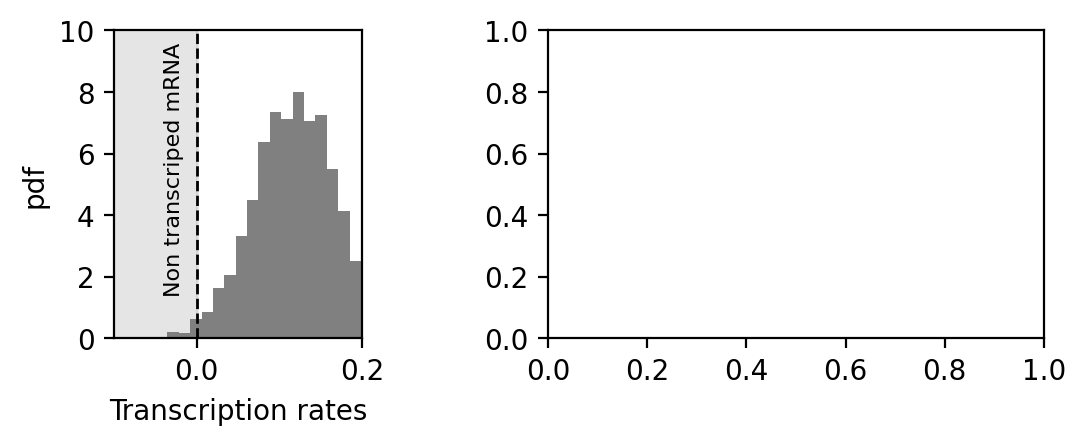

In [15]:
rates = rng.normal(size=3000)*5e-2 + 1.2e-1
# rates = rng.lognormal(1, 0.5, size=3000)/50 - 1.5e-2
decay_rates = rng.normal(size=3000)*1e-4 + 1.2e-3
decay_rates = np.ones(3000)*1.5e-3

countss = spawn_and_decay(rng, rates, decay_rates)
countss += 1e-5

fig, axs = plt.subplots(
    1,2,
    width_ratios = (1,2),
    figsize=(6,2),
    dpi=200,
)
fig.subplots_adjust(wspace=0.5)

ax = axs[0]
ax.hist(rates, bins=30, density=True, color='gray')
ax.set_xlabel('Transcription rates')
ax.set_ylabel('pdf')

ax.axvline(x=0, linestyle='--', linewidth=1, color='black')
ax.text(-0.04,1.5,'Non transcriped mRNA', rotation=90, fontsize=8)
ax.fill_between((-1,0),(0,0),(15,15), color='gray', alpha=0.2)
ax.set_xlim(-0.1,0.2)
ax.set_ylim(0,10)


ax = axs[1]
model = SOG(n_components=1)
model.fit(
    np.log(countss),
    30,
    np.array((
        (-1,100,1),
        (-1,-100,-1),
    ))
)

model.plot(ax, countss)

# ax.hist(countss, bins=30)


# Lognormality convergence?

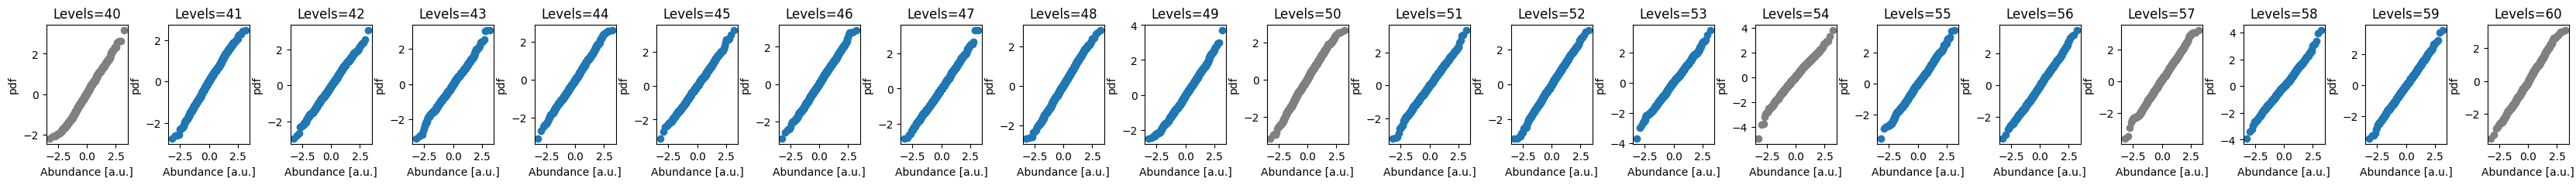

In [ ]:
# @jit
def compute_ratios(rng, levels):
    
    base = rng.normal(size=(2*levels,1000))*0.1 + 1

    res = np.ones(1000)
    for n in base[:levels]: res *= n

    for d in base[levels:]: res /= d
    
    return res



def nice_plot(rng, min_level, max_level):
    levels = max_level - min_level

    fig, axs = plt.subplots(1,levels+1, figsize=(levels*2+2, 2))
    fig.subplots_adjust(wspace=0.5)

    for ax, l in zip(axs, range(min_level,max_level+1)):
        log_dist = np.log(compute_ratios(rng, l))
        res = kstest(log_dist, cdf='norm')
        # res = normaltest(log_dist)

        color = 'gray' if res.pvalue < 0.05 else 'tab:blue'

        osm, osr = probplot(log_dist, fit=False)
        ax.scatter(osm, osr, color=color)
        ax.set_xlabel('Abundance [a.u.]')
        ax.set_ylabel('pdf')
        ax.set_title(f'Levels={l}')
        


rng = np.random.default_rng(2025)

nice_plot(rng, min_level=40, max_level=60)
    



# PDE

In [92]:
# FTCS algo

def gen_f(D,alpha,c1,c2, tau):

    @jit
    def f(u,p):
        # First diffuse u

        du = np.empty_like(u)
        dp = np.empty_like(p)

        du[1:-1] = D * (u[2:] + u[:-2] - 2*u[1:-1])
        du[0] = D * (u[1] - u[0])
        du[-1] = D * (u[-2] - u[-1])

        dp = alpha * u * (c2 - p)

        # Add the consumption to u
        du -= dp

        # Add decay of u
        du -= u/tau

        return du, dp

    return f

stepper = gen_f(0.01, 0.01, 1, 0.1, 100)

u0 = np.zeros(100)
u0[50] = 20
p0 = np.zeros(100)

ut = [u0,]
pt = [p0,]

for t in range(100000):
    du, dp = stepper(ut[-1], pt[-1])

    ut.append(ut[-1] + du)
    pt.append(pt[-1] + dp)


(0.0, 0.2)

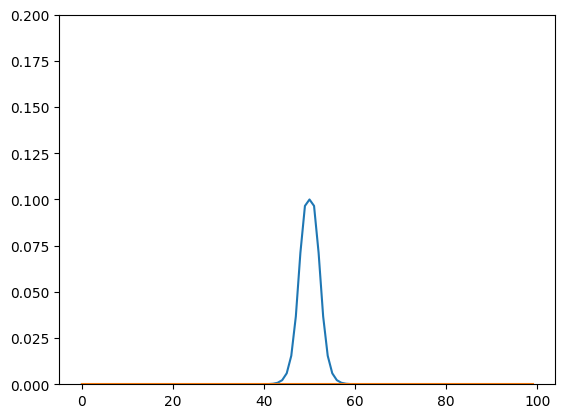

In [93]:
plt.plot(pt[-1])
plt.plot(ut[-1])
plt.ylim((0,.2))